In [2]:
from math import isnan
import os
import pandas as pd
%pip install pygeocodio
from geocodio import GeocodioClient
import requests
import sqlalchemy
%pip install colorama
from colorama import Fore, Style
from inspect import getframeinfo, stack
import smtplib, ssl
from datetime import datetime
from pytz import timezone
from sqlalchemy import create_engine
%pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()
%pip install CensusData


key = "a00cb79ec4f97e6760c49740b8ea7a7be6b77bb"
client = GeocodioClient(key)
censuskey = "8105419cada33ca0aaa48b111b8c44b9484e286a"

print(client)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import geopandas as gpd
%pip install censusdata
import censusdata as cd

Note: you may need to restart the kernel to use updated packages.


In [4]:
def myprint(message, is_red="", email_also=""):
    try:
        if email_also != "yes":
            frameinfo = getframeinfo((stack()[1][0]))
            file_and_line_info = Fore.LIGHTBLUE_EX + "  (" + frameinfo.filename.split("/")[-1] + ", line " + str(frameinfo.lineno) + ")" + Style.RESET_ALL
        else:
            file_and_line_info = ""
        if is_red == "red":
            print_red(message + file_and_line_info)
        else:
            print(message + file_and_line_info)
    except:
        print(message + "(there was an error with `myprint`)")
        
def create_address_from(address, city, state, zip):
    return handle_null(address) + ", " + handle_null(city) + " " + handle_null(state) + " " + handle_null(str(zip))

def handle_null(object):
    if pd.isnull(object):
        return ""
    else:
        return str(object)
    
def split_into_parts(a_list, max_items_per_part):
    if len(a_list) < max_items_per_part:
        return [a_list]
    else:
        num_parts = len(a_list) // max_items_per_part
        res = []
        start = 0
        end = max_items_per_part
        for num in range(num_parts):
            res.append(a_list[start:end])

            if num != num_parts - 1:
                start += max_items_per_part
                end += max_items_per_part

        res.append(a_list[end:])
        return res

In [6]:

# geocodes a DataFrame `df`, adding columns for latitude, longitude, accuracy, and accuracy type
# worksite_or_housing is either "worksite" or "housing" and specifies whether to geocode housing or worksite columns
# if `check_previously_geocoded, uses the materialized postgres view `previously_geocoded` to geocode addresses that
# we've already geocoded without using Geocodio so as to save credits
# return the DataFrame with geocoding results columns added

def geocode_table(df, worksite_or_housing, check_previously_geocoded=False):
    myprint(f"Geocoding {worksite_or_housing}...")

    if check_previously_geocoded:
        make_query("REFRESH MATERIALIZED VIEW previously_geocoded")
        
        if worksite_or_housing == "worksite":
            df["address_id"] = df.apply(lambda job: (handle_null(job["street_addr_1_txt"]) + handle_null(job["cty_nm"]) +
                                                     handle_null(job["st_cd"]) + handle_null(job["zip_cd"])).lower(), axis=1)
        else:
            df["address_id"] = df.apply(lambda job: (handle_null(job["HOUSING_ADDRESS_LOCATION"]) + handle_null(job["HOUSING_CITY"]) +
                                                     handle_null(job["HOUSING_STATE"]) + handle_null(job["HOUSING_POSTAL_CODE"])).lower(), axis=1)
        df["previously_geocoded"] = False
        df[f"{worksite_or_housing}_lat"] = None
        df[f"{worksite_or_housing}_long"] = None
        df[f"{worksite_or_housing} accuracy"] = None
        df[f"{worksite_or_housing} accuracy type"] = ""

        errors = 0
        for i, job in df.iterrows():
            # won't work if the full address has certain special characters. should probably fix this but it's rather rare
            try:
                previous_geocode = pd.read_sql(f"""SELECT * FROM previously_geocoded WHERE full_address = '{job["address_id"]}'""", con=engine)
            except:
                previous_geocode = pd.DataFrame()
                print(f"""Failed to query previously_geocoded for address '{job["address_id"]}', the {i + 1}th row.""")
                errors += 1
            if not previous_geocode.empty:
                myprint(f"""'{job["address_id"]}' - the {i + 1}th row - is previously geocoded.""")
                assert len(previous_geocode) == 1
                df.at[i, f"{worksite_or_housing}_lat"] = get_value(previous_geocode, "latitude")
                df.at[i, f"{worksite_or_housing}_long"] = get_value(previous_geocode, "longitude")
                df.at[i, f"{worksite_or_housing} accuracy"] = get_value(previous_geocode, "accuracy")
                df.at[i, f"{worksite_or_housing} accuracy type"] = get_value(previous_geocode, "accuracy_type")
                df.at[i, "previously_geocoded"] = True

        print(f"There were {errors} errors checking for previous geocoding.")
        df = df.drop(columns=["address_id"])

        previously_geocoded = df[df["previously_geocoded"]]
        df = df[~(df["previously_geocoded"])]

        print(f"{len(previously_geocoded)} rows have already been geocoded and {len(df)} rows still need to be geocoded.")

        df = df.drop(columns=["previously_geocoded"])
        previously_geocoded.drop(columns=["previously_geocoded"], inplace=True)

    if not df.empty:

        if worksite_or_housing == "worksite":
            addresses = df.apply(lambda job: create_address_from(job["street_addr_1_txt"], job["cty_nm"], job["st_cd"], job["zip_cd"]), axis=1).tolist()
        elif worksite_or_housing == "housing":
            addresses = df.apply(lambda job: create_address_from(job["HOUSING_ADDRESS_LOCATION"], job["HOUSING_CITY"], job["HOUSING_STATE"], job["HOUSING_POSTAL_CODE"]), axis=1).tolist()
        else:
            print_red_and_email("`worksite_or_housing` parameter in geocode_table function must be either `worksite` or `housing` or `housing addendum`", "Invalid Function Parameter")
            return

        # handles case of more than 10000 addresses - because geocodio api won't batch geocode with more than 10000 addresses at once
        addresses_split = split_into_parts(addresses, 9999)
        geocoding_results = []
        for these_addresses in addresses_split:
            geocoding_results += client.geocode(these_addresses)
        assert len(geocoding_results) == len(addresses)


        latitudes, longitudes, accuracies, accuracy_types, i = [], [], [], [], 0
        for result in geocoding_results:
            try:
                results = result['results'][0]
                accuracies.append(results['accuracy'])
                accuracy_types.append(results['accuracy_type'])
                latitudes.append(results['location']['lat'])
                longitudes.append(results['location']['lng'])
            except:
                accuracies.append(None)
                accuracy_types.append(None)
                latitudes.append(None)
                longitudes.append(None)
            i +=1

        i = len(df.columns)
        df[f"{worksite_or_housing}_lat"] = latitudes
        df[f"{worksite_or_housing}_long"] = longitudes
        df[f"{worksite_or_housing} accuracy"] = accuracies
        df[f"{worksite_or_housing} accuracy type"] = accuracy_types
        myprint(f"Finished geocoding {worksite_or_housing}.")

    if check_previously_geocoded:
        df = df.append(previously_geocoded)

    # # uncomment to save excel file with geocoding results
    # now = datetime.now(tz=timezone('US/Eastern')).strftime("%I.%M%.%S_%p_%B_%d_%Y")
    # df.to_excel(f"geocoded_{now}.xlsx")
    # myprint("Backed up geocoding results")

    return df

# geocodes `df` and returns two dataframes - one with accuratly geocoded rows and one with inaccurate rows
def geocode_and_split_by_accuracy(df, table=""):
    if table == "dol_h2b":
        df = geocode_table(df, "worksite", check_previously_geocoded=True)
    elif table == "housing addendum":
        df = geocode_table(df, "housing", check_previously_geocoded=True)
    elif table == "dol_h2a":
        df = geocode_table(df, "worksite", check_previously_geocoded=True)
        df = geocode_table(df, "housing", check_previously_geocoded=True)
    else:
        df = geocode_table(df, "worksite")
        if "HOUSING_ADDRESS_LOCATION" in df.columns:
            df = geocode_table(df, "housing")
        else:
            print_red_and_email("Not geocoding housing because HOUSING_ADDRESS_LOCATION is not present. This should be fine, and hopefully just means there were only H-2B jobs in today's run, but you may want to check.", "Not geocoding housing today")

    housing_addendum = (table == "housing addendum")
    accurate = df.apply(lambda job: is_accurate(job, housing_addendum=housing_addendum), axis=1)
    accurate_jobs, inaccurate_jobs = df.copy()[accurate], df.copy()[~accurate]
    inaccurate_jobs["fixed"] = False

    myprint(f"There were {len(accurate_jobs)} accurate jobs.\nThere were {len(inaccurate_jobs)} inaccurate jobs.")

    return accurate_jobs, inaccurate_jobs

In [7]:
url = "https://enfxfr.dol.gov/data_catalog/WHD/whd_whisard_20210415.csv.zip"
raw_dol = pd.read_csv(url, 
                      index_col=None,
                      dtype={7:'string'})
raw_dol['findings_start_date'] = pd.to_datetime(raw_dol['findings_start_date'], errors='coerce')
raw_dol['findings_end_date'] = pd.to_datetime(raw_dol['findings_end_date'], errors='coerce')
print(f'raw dataframe has {len(raw_dol.columns)} columns and {len(raw_dol)} rows')

raw dataframe has 110 columns and 313928 rows


In [49]:
list_states= ['TX', 'MS', 'LA', 'KY', 'AL', 'TN']
raw_dol_states = raw_dol[raw_dol["st_cd"].isin(list_states)]
raw_dol_states = raw_dol_states[raw_dol_states["h2a_violtn_cnt"] > 0]
raw_dol_states = raw_dol_states[raw_dol_states["ld_dt"] >= "2016-1-1"]
#raw_dol_states = raw_dol_states[["street_addr_1_txt", "cty_nm", "st_cd", "zip_cd", "naic_cd", "h2a_violtn_cnt"]]
# 806 rows
raw_dol_states.ld_dt

32374     2016-11-07 01:00:04 EST
32578     2016-11-07 01:00:04 EST
32689     2016-11-07 01:00:04 EST
33130     2016-11-07 01:00:04 EST
33515     2016-11-07 01:00:04 EST
                   ...           
313236    2021-04-15 00:18:42 EDT
313237    2021-04-15 00:18:42 EDT
313238    2021-04-15 00:18:42 EDT
313239    2021-04-15 00:18:42 EDT
313477    2021-04-15 00:18:42 EDT
Name: ld_dt, Length: 329, dtype: object

In [51]:
def subset_state(data, abbr):
    df = data[data["st_cd"] == abbr].copy()
    geo_tab = geocode_table(df, "worksite", check_previously_geocoded=False)
    gdf = gpd.GeoDataFrame(geo_tab, 
                             geometry=gpd.points_from_xy(geo_tab.worksite_long, geo_tab.worksite_lat))
    return(gdf)



In [52]:
texas = subset_state(raw_dol_states, "TX")
mississippi = subset_state(raw_dol_states, "MS")
louisiana = subset_state(raw_dol_states, "LA")
kentucky = subset_state(raw_dol_states, "KY")
tennessee = subset_state(raw_dol_states, "TN")
alabama = subset_state(raw_dol_states, "AL")

Geocoding worksite...  (<ipython-input-6-ab3785178427>, line 8)
Finished geocoding worksite.  (<ipython-input-6-ab3785178427>, line 92)
Geocoding worksite...  (<ipython-input-6-ab3785178427>, line 8)
Finished geocoding worksite.  (<ipython-input-6-ab3785178427>, line 92)
Geocoding worksite...  (<ipython-input-6-ab3785178427>, line 8)
Finished geocoding worksite.  (<ipython-input-6-ab3785178427>, line 92)
Geocoding worksite...  (<ipython-input-6-ab3785178427>, line 8)
Finished geocoding worksite.  (<ipython-input-6-ab3785178427>, line 92)
Geocoding worksite...  (<ipython-input-6-ab3785178427>, line 8)
Finished geocoding worksite.  (<ipython-input-6-ab3785178427>, line 92)
Geocoding worksite...  (<ipython-input-6-ab3785178427>, line 8)
Finished geocoding worksite.  (<ipython-input-6-ab3785178427>, line 92)


In [53]:
censuskey = "8105419cada33ca0aaa48b111b8c44b9484e286a"
test = requests.get("https://api.census.gov/data/2020/dec/responserate?get=NAME,GEO_ID,DRRALL,CRRINT,RESP_DATE,CRRALL,DRRINT&for=tract:*&in=state:01&key=8105419cada33ca0aaa48b111b8c44b9484e286a")


#shape = requests.get("https://api.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
#print(test)

alabama.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 29 entries, 218317 to 311513
Columns: 115 entries, case_id to geometry
dtypes: datetime64[ns](2), float64(45), geometry(1), int64(57), object(9), string(1)
memory usage: 26.3+ KB


In [13]:
%pip install geopandas
al_data = gpd.read_file("../tl_2016_01_tract")
ky_data = gpd.read_file("../tl_2016_21_tract")
la_data = gpd.read_file("../tl_2016_22_tract")
ms_data = gpd.read_file("../tl_2016_28_tract")
tn_data = gpd.read_file("../tl_2016_47_tract")
tx_data = gpd.read_file("../tl_2016_48_tract")


Note: you may need to restart the kernel to use updated packages.


In [14]:
%matplotlib inline
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay, sjoin

In [54]:
alabama_join = sjoin(alabama, al_data, how="inner", op = "intersects")
louisiana_join = sjoin(louisiana, la_data, how="inner", op = "intersects")
kentucky_join = sjoin(kentucky, ky_data, how="inner", op = "intersects")
tennessee_join = sjoin(tennessee, tn_data, how="inner", op = "intersects")
texas_join = sjoin(texas, tx_data, how="inner", op = "intersects")
mississippi_join = sjoin(mississippi, ms_data, how="inner", op = "intersects")

<ipython-input-54-5f53cb70540b>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  alabama_join = sjoin(alabama, al_data, how="inner", op = "intersects")
<ipython-input-54-5f53cb70540b>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  louisiana_join = sjoin(louisiana, la_data, how="inner", op = "intersects")
<ipython-input-54-5f53cb70540b>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  kentucky_join = sjoin(kentucky, ky_data, how="inner", op = "intersects")
<ipython-inpu

In [17]:
mississippi_join.info()
#something is wrong with this 

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 118 entries, 174 to 313238
Columns: 128 entries, case_id to INTPTLON
dtypes: datetime64[ns](2), float64(45), geometry(1), int64(60), object(19), string(1)
memory usage: 118.9+ KB


In [276]:
final = pd.concat([alabama_join, texas_join, tennessee_join, kentucky_join, louisiana_join, mississippi_join], ignore_index = True)
final = final[["case_id", "trade_nm" ,"legal_name","street_addr_1_txt", "cty_nm", "st_cd", "zip_cd", "h2a_violtn_cnt", "worksite_lat", "worksite_long", "TRACTCE", "GEOID", "geometry"]]
#print(final)
sum_violations = final.groupby("GEOID").sum("h2a_violtn_cnt")
len(sum_violations.case_id.unique())
sum_violations = pd.DataFrame(sum_violations).reset_index()
sum_violations.head()

,GEOID,case_id,zip_cd,h2a_violtn_cnt,worksite_lat,worksite_long
0,01003010703,3661237,73052.0,2,61.177742,-175.642059
1,01003010903,1830614,36551.0,1,30.580945,-87.776318
2,01005950400,1650094,36016.0,12,31.721210,-85.464301
3,01011952200,1828252,36089.0,1,32.142191,-85.742406
4,01021060102,3720022,70090.0,4,65.709027,-173.267166


In [65]:
# clean geo ID
# load ACS data
# add leading zeros to geo id
# subset to tracts in the 6 states
#merge
# merge to geo data on acs demographics
# left join to violations based on geo id
# if missing in join violations = 0

In [20]:
%pip install census
#!pip install us
from census import Census

Note: you may need to restart the kernel to use updated packages.


In [44]:
c = Census("8105419cada33ca0aaa48b111b8c44b9484e286a")

def demographics(variables_list, state_code):
    list_dem = c.acs5.state_county_tract(
        variables_list,
        state_fips=state_code,
        year = 2016,
        county_fips=Census.ALL,
        tract=Census.ALL)
    df = pd.DataFrame(list_dem)
    return df

In [56]:
var_names = ["B03001_003E", "B01003_001E", "NAME"]

texas = demographics(var_names, "48")
mississippi = demographics(var_names, "28")
louisiana = demographics(var_names, "22")
alabama = demographics(var_names, "01")
tennessee = demographics(var_names, "47")
kentucky = demographics(var_names, "21")

In [273]:
final_df = pd.concat([texas, mississippi, louisiana, alabama, tennessee, kentucky])
final_df["perc_hispanic"] = final_df["B03001_003E"]/final_df["B01003_001E"]
final_df["state_abbrv"] = final_df["state"].replace({"48": "TX", "28": "MS", "22": "LA", "01": "AL", "47": "TN", "21": "KY"})
final_df_subset = final_df[["B03001_003E", "B01003_001E", "NAME", "state", 
                            "tract", "county", "state_abbrv", "perc_hispanic"]].reset_index()
final_df_subset.head()

,index,B03001_003E,B01003_001E,NAME,state,tract,county,state_abbrv,perc_hispanic
0,0,2424.0,6580.0,"Census Tract 3503, Harris County, Texas",48,350300,201,TX,0.368389
1,1,742.0,5458.0,"Census Tract 4102, Harris County, Texas",48,410200,201,TX,0.135947
2,2,550.0,3396.0,"Census Tract 4113, Harris County, Texas",48,411300,201,TX,0.161955
3,3,259.0,3458.0,"Census Tract 4119, Harris County, Texas",48,411900,201,TX,0.074899
4,4,1091.0,2605.0,"Census Tract 4202, Harris County, Texas",48,420200,201,TX,0.418810


In [277]:
final_df_subset["GEOID_pasted"] = final_df_subset.state.astype(str) + final_df_subset.county.astype(str) + final_df_subset.tract.astype(str)

final_df_subset.head()
final_df_subset.GEOID_pasted.str.len().value_counts()
len(set(final_df_subset.GEOID_pasted.unique()).intersection(set(final.GEOID.unique())))
final.head()
len(sum_violations.GEOID.unique())

232

In [226]:
merge = pd.merge(final_df_subset, sum_violations, how = "left", left_on = "GEOID_pasted", right_on = "GEOID", suffixes = ["_acs", "_violations"], indicator = "_inviol")
#merge.drop_duplicates
merge.head()
merge["Latitude"] = merge["worksite_lat"]
merge["Longitude"] = merge["worksite_long"]
merge.Longitude.value_counts()

alabama_to_merge = merge[merge["state"] == "01"]
#alabama_to_merge.Longitude.value_counts()
#merge[["street_addr_1_txt", "st_cd", "h2a_violtn_cnt", "tract", "TRACTCE", "perc_hispanic"]]

-173.267166    1
-87.776318     1
-174.589965    1
-88.345820     1
-175.642059    1
-85.996576     1
-85.742406     1
-86.483290     1
-87.549795     1
-85.696652     1
-176.551198    1
-170.445930    1
-86.132381     1
-171.828256    1
-260.149498    1
-88.240145     1
-88.343410     1
-88.292927     1
-88.272544     1
-85.464301     1
-87.688789     1
Name: Longitude, dtype: int64

In [258]:
al_shp = gpd.read_file("../cb_2016_01_tract_500k")
print(len(alabama_to_merge))

alabama_plot = pd.merge(al_shp, alabama_to_merge, how = "left", left_on = "GEOID", right_on = "GEOID_pasted", suffixes = ["_shape", "_violations"], indicator = "merge")

alabama_plot["merge"].value_counts()
alabama_plot["perc_hispanic"] = alabama_plot["perc_hispanic"]*100

## trying to create a geometry column out of the lat and long column
## unsuccessful


1181


<ipython-input-258-c5161acb1efa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alabama_to_merge["geometry"] = (alabama_to_merge[['Latitude', 'Longitude']].itertuples(index=False))


In [257]:
print(alabama_to_merge.geometry.value_counts())

<zip object at 0x7fb8ee9fc580>    1181
Name: geometry, dtype: int64


AttributeError: No geometry data set yet (expected in column 'geometry'.)

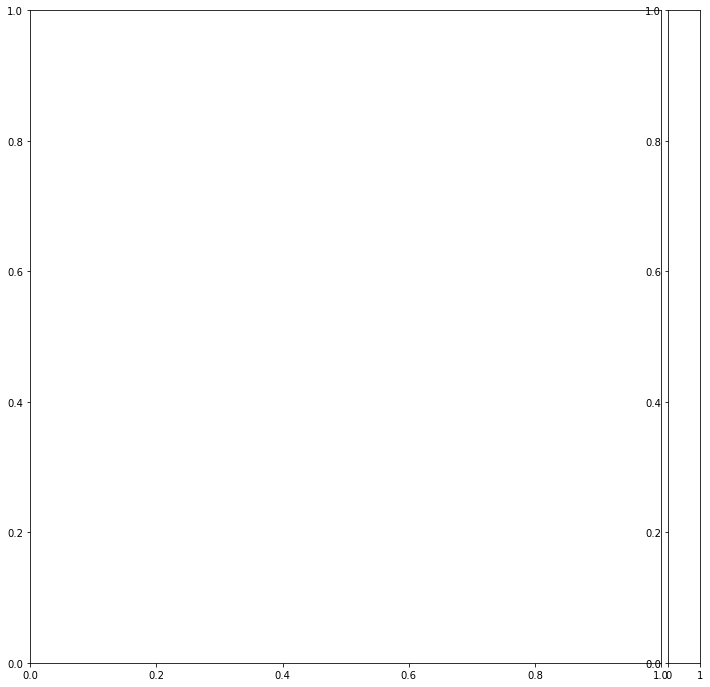

In [254]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


#alabama_plot.plot()

fig, ax = plt.subplots(figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
alabama_plot.plot(ax=ax, 
                        column='perc_hispanic', 
                        cmap='Purples',
                        edgecolor='grey',
                        linewidth = .1,
                        legend=True, 
                        cax=cax,
                        missing_kwds={"color": "lightgrey"})
alabama_to_merge.plot(ax=ax, column = "h2a_violtn_cnt", color = "red")
#ax.scatter(x = "worksite_long", y = "worksite_lat", marker="*", color='r', alpha=0.7, s = "h2a_violtn_cnt")
#alabama_plot.plot(x = "worksite_long", y = "worksite_lat", column = "h2a_violtn_cnt", ax = ax, kind = "scatter")
ax.set_title('Alabama', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
#plt.savefig('images/choropleth.png')